I work with an urban magnetometry group that has been collecting data on the magnetic fields in urban settings. For example they have several magnetometers around the physics buildings and collect data a couple of days at a time. The magnetometers are set to automatically upload the data to a google drive. From there we can perform all sorts of analyses. I am rather new to the group but have been looking for an opportunity to jump in and contribute/participate. Along that same vein, I would like to add the disclaimer that I originally knew nothing about timeseries analyses and signal processing so the results of this final project are sure to be underwhelming because a lot of the work went into actually learning about that stuff.

The goal of this project is basically to familiarize myself with the data and analysis techniques that the group uses. Along the way, I hoped to implement some python things that I have learned this semester. For reference and to get started I had some old python 2 and IDL scripts. When I proposed the project, I actually didn't realize I would have some python 2 scripts but it's been helpful and made the process less painful.

The first improvement I made on the code was to create a repository with information on the location of the magnetometers at any time. These locations are basically just used to correct for timezone issues so rough locations have been fine. I would have loved to use the PSQL formatting that we learned this semester, but it was pretty impractical considering that we only needed 3 informations: station (basically magnetometer id), date, location. Instead, that information would be much easier to put into a google sheet. So I created a couple functions to access the data from the google sheet. All one would need is the .json authorization key which is easy to send around.

Further work was then implemented in wavelet analysis and fourier analyses. Note, most of this had sample python2 code in it so it is not original. This is mostly done with machine learning algorithms (think pymc for timeseries analyses). The program here uses pyml but I'm sure that equivalents can be found in Scikit-learn.

As for demonstration of the work that I have done, there isn't really a whole lot of show and tell. Significant issues with a broken gcc has hampered the timeliness of my work. However, I present some basic fourier analysis along with the code that I used to implement it. Note that there is quite a bit of behind the scenes programs that can be used to download the data (assuming that you have access to the google drive and skicka installed). I include those in this same github repository but, since it works on my installation, am not making too much 

In [32]:
import time,glob,re,struct,astropy,h5py,sys,math,os,pytz
import numpy as np
from oauth2client.service_account import ServiceAccountCredentials
from astropy.time    import Time
from datetime        import datetime,timedelta,date
from dateutil        import tz
from gwpy.timeseries import TimeSeries
from itertools       import combinations
from scipy           import signal
from tzwhere         import tzwhere
import json
import gspread

Below is the basic code used to interact with the google sheet. It requires the json key. I am not including the key in the repository for obvious reasons but I can send it separately.

In [11]:
json_key = json.load(open("magnetometer move dates-79f1a9e8e6e2.json")) 
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
# get email and key from creds
credentials = ServiceAccountCredentials.from_json_keyfile_name("magnetometer move dates-79f1a9e8e6e2.json", scope)
# authenticate with Google
file = gspread.authorize(credentials)
# open sheet
sheet = file.open("magnetometor_move_days").sheet1 
stations,dates,locs = sheet.col_values(1),sheet.col_values(2),sheet.col_values(3)
final = []
for i in range(1,5):
    #get dates and locations for station
    relevantdates = [dates[x] for x in range(0,len(dates)) if stations[x]==str(i)]
    relevantlocs = [locs[x] for x in range(0,len(dates)) if stations[x]==str(i)]
    #sort the lists according to date
    relevantdates,relevantlocs = [x for x,y in sorted(zip(relevantdates,relevantlocs))],[y for x,y in sorted(zip(relevantdates,relevantlocs))]
    #append the lists
    toappend = []
    for j in range(len(relevantdates)-1,-1,-1):
        if(j==len(relevantdates)-1):
            #need to split the str to pass as ints
            datestr = relevantdates[j].split(",")
            final.append([i, datetime(int(datestr[0]),int(datestr[1]),int(datestr[2])), datetime.max, tz.gettz(relevantlocs[j])])
            
        else:
            #need to split the str to pass as ints
            datestr_start = relevantdates[j].split(",")
            datestr_end = relevantdates[j-1].split(",")
            final.append([i, datetime(int(datestr_start[0]),int(datestr_start[1]),int(datestr_start[2])), 
                          datetime(int(datestr_end[0]),int(datestr_end[1]),int(datestr_end[2])), tz.gettz(relevantlocs[j-1])])
print(np.asarray(final))

[[1 datetime.datetime(2017, 12, 3, 0, 0)
  datetime.datetime(9999, 12, 31, 23, 59, 59, 999999)
  tzfile('/usr/share/zoneinfo/America/New_York')]
 [1 datetime.datetime(2015, 11, 1, 0, 0)
  datetime.datetime(2017, 12, 3, 0, 0)
  tzfile('/usr/share/zoneinfo/America/New_York')]
 [2 datetime.datetime(2015, 11, 1, 0, 0)
  datetime.datetime(9999, 12, 31, 23, 59, 59, 999999)
  tzfile('/usr/share/zoneinfo/America/Los_Angeles')]
 [3 datetime.datetime(2017, 10, 6, 0, 0)
  datetime.datetime(9999, 12, 31, 23, 59, 59, 999999)
  tzfile('/usr/share/zoneinfo/America/New_York')]
 [3 datetime.datetime(2015, 11, 1, 0, 0)
  datetime.datetime(2017, 10, 6, 0, 0)
  tzfile('/usr/share/zoneinfo/America/New_York')]
 [4 datetime.datetime(2017, 12, 3, 0, 0)
  datetime.datetime(9999, 12, 31, 23, 59, 59, 999999)
  tzfile('/usr/share/zoneinfo/America/New_York')]
 [4 datetime.datetime(2015, 11, 1, 0, 0)
  datetime.datetime(2017, 12, 3, 0, 0)
  tzfile('/usr/share/zoneinfo/America/New_York')]]


Here I define the functions that collect the data from the google drive online (assuming you have skicka) and the functions that would throw the data into our required data arrays. A simplistic version is employed in the cell following it.

In [33]:
#%%writefile extract_ported.py
def get_loc_array(cred = "magnetometer move dates-79f1a9e8e6e2.json"):
    """
    Will retrieve the locations of the magnetometers.
    
    Parameters
    ----------
    cred: str
      Name of the json file with the credentials to access the google sheet
    """
    
    json_key = json.load(open(cred)) 
    scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
    # get email and key from creds
    credentials = ServiceAccountCredentials.from_json_keyfile_name("magnetometer move dates-79f1a9e8e6e2.json", scope)
    # authenticate with Google
    file = gspread.authorize(credentials)
    # open sheet
    sheet = file.open("magnetometor_move_days").sheet1 
    stations,dates,locs = sheet.col_values(1),sheet.col_values(2),sheet.col_values(3)
    final = []
    for i in range(1,5):
        #get dates and locations for station
        relevantdates = [dates[x] for x in range(0,len(dates)) if stations[x]==str(i)]
        relevantlocs = [locs[x] for x in range(0,len(dates)) if stations[x]==str(i)]
        #sort the lists according to date
        relevantdates = [x for x,y in sorted(zip(relevantdates,relevantlocs))]
        relevantlocs = [y for x,y in sorted(zip(relevantdates,relevantlocs))]
        #append the lists
        for j in range(len(relevantdates)-1,-1,-1):
            if(j==len(relevantdates)-1):
                #need to split the str to pass as ints
                datestr = relevantdates[j].split(",")
                final.append([i, datetime(int(datestr[0]),int(datestr[1]),int(datestr[2])),
                              datetime.max, tz.gettz(relevantlocs[j])])
            else:
                #need to split the str to pass as ints
                datestr_start = relevantdates[j].split(",")
                datestr_end = relevantdates[j-1].split(",")
                final.append([i, datetime(int(datestr_start[0]),int(datestr_start[1]),int(datestr_start[2])), 
                              datetime(int(datestr_end[0]),int(datestr_end[1]),int(datestr_end[2])),
                              tz.gettz(relevantlocs[j-1])])
    return np.asarray(final)

def get_offset(t0,t1,zone,station,gps,locations):
    """
    Determine UTC to local Local offset to be applied.
    
    Parameters
    ----------
    t0 : datetime
      Starting timestamp
    t1 : datetime
      End timestamp
    zone : str
      Define timing zone, either Local or UTC
    city : str
      City where the sensor is located
    locations: np.array
        pass the array with locations and times (obtained from get_loc_array)

    Return
    ------
    offset : datetime
      Offset time to match time in targeted filename 
    """
    # Identifying the time zone
    utc_zone = tz.gettz('UTC')
    # Format input timestamp into UTC time
    utc_epoch = t0.replace(tzinfo=utc_zone)
    # Get time in local California time
    local_epoch = utc_epoch.astimezone(tz.gettz('America/Los_Angeles'))
    # Calculate offset between UTC and PST timestamps
    utc2pst = datetime.utcoffset(local_epoch).total_seconds()
    # Consider UTC to PST offset if requested time is before fix date
    utc2pst = utc2pst if t0<datetime(2017,12,7) else 0
    
    # Identify the location for requested data
    for n,start,end,loc in locations:
        if n==station and start<t0<end:
            local_zone = loc
    # Identifying the time zone
    utc_zone = tz.gettz('UTC')
    # Format input timestamp into UTC time
    utc_epoch = t0.replace(tzinfo=utc_zone)
    # Get time in local California time
    local_epoch = utc_epoch.astimezone(local_zone)
    # Calculate offset between Local and UTC timestamps
    utc2local = datetime.utcoffset(local_epoch).total_seconds()
    # Check if first version of timing data
    if t1<datetime(2016,6,10):
        # Calculate offset between provided UTC to local timestamps
        offset = -utc2local if zone=='UTC' else 0
    # Check if second version of timing data
    if t0>datetime(2016,6,10):
        # Calculate offset between provided local to UTC timestamps
        offset = -utc2local if zone=='Local' and gps=='on' else 0
    return utc2local,offset,utc2pst
 
def get_time(filename,downfactor=1,utc2local=0,utc2pst=0,zone='Local'):
    """
    Read timing binary file and construct full timestamp array.

    Parameters
    ----------
    filename : str
      Path to the timing binary file
    downfactor : float
      Down-sampling rate, default is 1
    offset : datetime
      Offset time to match time in targeted filename 
    zone : str
      Define timing zone, either Local or UTC
    
    Return
    ------
    tgps : numpy.array
      Reconstructed full timing array
    """
    # Read binary file and store data in array
    with open(filename,'rb') as f:
        data = f.read()
    f.close()
    # Check timing version
    if 'time_v2' in filename:
        # Define the total number records (63 bytes per record)
        size = int(len(data)/63)
        # Unpack each record as the following succession:
        data = struct.unpack('<'+'qI?Qddcdcdd'*size,data)
        # Reshape array into 2D format
        data = numpy.array(data,dtype=object).reshape((size,11))
        # Correct for applied constant UTC/PST offset
        data[:,4] += utc2pst
        # Depending on UTC argument, convert Local timestamps into UTC format
        offset = utc2local if zone=='Local' else 0
        # Create incremented sample index array
        x = numpy.array(data[:,0]+data[:,1],dtype=float)
        # Defined timestamp array
        y = numpy.array(data[:,4]+offset)
        # Fit timestamp array
        popt,pcov = numpy.polyfit(x,y,1,cov=True)
        # Create full sample index array
        xfit = numpy.arange(x[-1])
        # Construct full timestamp array
        tgps = numpy.polyval(popt,xfit)
    else:
        data = data[7:]
        # Define the total number records (28 bytes per record)
        size = int(len(data)/28)
        # Unpack each record as the following succession:
        data = struct.unpack('<'+'qiQd'*size,data)
        # Reshape array so that each row corresponds to one record
        data = numpy.reshape(data,(size,4))
        # Convert timestamp into 
        data[:,2] = [(int(i) & 0x7fffffffffffffff)/1e7 for i in data[:,2]]
        # Correct timestamp from offset between system clock and UTC time
        data[:,2]-=(datetime(1970,1,1)-datetime(1,1,1)).total_seconds()
        # Correct for applied constant UTC/PST offset
        data[:,2] += utc2pst
        # Depending on UTC argument, convert Local timestamps into UTC format
        offset = utc2local if zone=='UTC' else 0
        # Create incremented sample index array
        x = data[:,0]+data[:,1]
        # Defined timestamp array
        y = data[:,2]+offset
        # Fit timestamp array
        popt,pcov = numpy.polyfit(x,y,1,cov=True)
        # Create full sample index array
        xfit = numpy.arange(x[-1])
        # Construct full timestamp array
        tgps = numpy.polyval(popt,xfit)
    # Downsample time and data arrays
    tgps = tgps[::downfactor] if downfactor==1 else tgps[::downfactor][:-1]
    return numpy.array(tgps)

def get_data(t0=None,t1=None,sample=False,sample_rate=3960,downfactor=1,zone='Local',seg=60,rates=[],
             station=None,verbose=False,dtype='scalar',rep='/media/shared/nuridata/4/22/18',gps='on'):
    """
    Glob all files withing user-defined period and extract data.
        
    Parameters
    ----------
    t0 : str
      Starting time in format YYYY-MM-DD-HH-MM
    t1 : str
      Ending time in format YYYY-MM-DD-HH-MM
    sample : bool
      Whether we read all the available data or only relevant files, default is False
    sample_rate : float
      Data sampling rate, default is 3960 Hz
    downfactor : float
      Down-sampling rate, default is 1
    zone : str
      Define timing zone, either Local or UTC
    rates : list
      List of successive value to decimate the data from
    station : int
      Station number
    dtype : str
      Type of output value, default is the scalar magnitude among all directions.
    rep : str
      Path in which the data are stored.
    
    Return
    ------
    ts : gwpy.timeseries.TimeSeries
      Time series data, either scalar magnitude or for individual direction.
    """
    downfactor = downfactor if len(rates)==0 else reduce(lambda x, y: x*y, rates)
    data_path = rep if sample else '%s/NURI-station-%02i'%(rep,station)
    # Check whether sample mode set or start and end timestamp defined
    if sample:
        dataset = glob.glob('%s/*time*.bin'%data_path)
    elif t0!=None and t1!=None:
        # Convert start and end dates into datetime objects
        t0 = datetime(*numpy.array(t0.split('-'),dtype=int))
        t1 = datetime(*numpy.array(t1.split('-'),dtype=int))
        # Calculate Local-UTC time difference and offset to be applied to filenames
        utc2local, offset, utc2pst = get_offset(t0,t1,zone,station,gps,get_loc_array())
        # Initialise dataset array
        dataset = []
        # Loop through all requested hours
        for date in numpy.arange(t0+timedelta(seconds=offset),t1+timedelta(seconds=offset),timedelta(hours=1)):
            # Convert date into readable datetime format
            date = date.astype(datetime)
            # Determine timing binary filename
            path = '%s/NURI-station-%02i/'%(rep,station)+date.strftime("%Y-%-m-%-d_%-H-xx_time*.bin")
            # Search for the file and add it into storing array
            dataset += glob.glob(path)
    ts,t,x,y,z = [],[],[],[],[]
    if len(dataset)>0:
        for tfile in dataset:
            # Display file index in list
            if verbose: print(tfile.split('/')[-1])
            # Extract data from timing file
            times = get_time(tfile,downfactor) if sample else get_time(tfile,downfactor,utc2local,utc2pst,zone)
            #t = numpy.hstack((t,times))
            t.extend(times)
            # Check version of the timing
            version = 'time_v2' if 'time_v2' in tfile else 'time'
            # Extract data from X direction file
            xfile = tfile.replace(version,'rawX_uT_3960Hz')
            x.extend(read_axis(xfile,downfactor,rates,seg))
            # Extract data from Y direction file
            yfile = tfile.replace(version,'rawY_uT_3960Hz')
            y.extend(read_axis(yfile,downfactor,rates,seg))
            # Extract data from Z direction file
            zfile = tfile.replace(version,'rawZ_uT_3960Hz')
            z.extend(read_axis(zfile,downfactor,rates,seg))
        # Create individual time series if single axis requested
        if dtype=='xyz':
            x = TimeSeries(x,sample_rate=sample_rate/downfactor,epoch=t[0])
            y = TimeSeries(y,sample_rate=sample_rate/downfactor,epoch=t[0])
            z = TimeSeries(z,sample_rate=sample_rate/downfactor,epoch=t[0])
            ts = (x,y,z)
        # Create full magnitude time series if scalar type selected
        if dtype=='scalar':
            ts = numpy.vstack((x,y,z)).T
            ts = numpy.sqrt(numpy.sum(abs(ts)**2,axis=1))
            ts = TimeSeries(ts,sample_rate=sample_rate/downfactor,epoch=t[0])
    return ts

def read_axis(filename,downfactor,rates,seg):
    """
    Read the binary file of magnetic field axis.

    Parameters
    ----------
    filename : str
      Path to data file
    downfactor : float
      Resampling factor to downsample the data
    rates : list
      List of successive value to decimate the data from
    seg : int
      Number of seg to split data for faster downsampling

    Return
    ------
    data : numpy.array
      Magnetic field data.
    """
    # Read binary file and sore data in array
    with open(filename,'rb') as f:
        data = f.read()
    f.close()
    # Define the total number records (63 bytes per record)
    size = len(data)/8
    # Unpack each record
    data = numpy.array(struct.unpack('d'*size,data))
    if downfactor>1:
        # Determine number of sample in 10-minute chunk of data
        n = 3960*seg
        # Resample each 10-minute chunk of data for faster processing
        chunks = []
        for i in xrange(0, len(data), n):
            if len(data)-i>downfactor:
                chunk = data[i:i+n]
                chunk = signal.resample(chunk,len(chunk)/downfactor)
                chunks.extend(chunk)
    return data if downfactor==1 else chunks

def get_coord(filename):
    """
    Extracted longitude and latitude from version 2 timing data files.

    Parameters
    ----------
    filename : str
      Name of the timing binary file.

    Return
    ------
    lat, lon : float
      Latitute and Longitude of the magnetic sensor.
    """
    with open(filename,'rb') as f:
        data = f.read()
    f.close()
    s = len(data)/63
    data = struct.unpack('<'+'qipQddcdcdd'*s,data)
    data = numpy.reshape(data,(s,11))
    lat  = float(str(float(data[0,5])/100).split('.')[0])
    lat  = lat + (float(data[0,5])-lat*100)/60
    lat  = -lat if data[0,8]=='S' else lat
    lon  = float(str(float(data[0,7])/100).split('.')[0])
    lon  = lon + (float(data[0,7])-lon*100)/60
    lon  = -lon if data[0,6]=='W' else lon
    return lat,lon

def get_gnome(station,t0,t1,local=False,
              rep='/media/shared/nuridata'):
    """
    Glob all files withing user-defined period and extract data.

    Parameters
    ----------
    station : str
      Name of the station to be analysed
    t0 : str
      Starting time in format YYYY-MM-DD-HH-MM
    t1 : str
      Ending time in format YYYY-MM-DD-HH-MM
    local : bool
      Whether we extract local (GPS) or universal (UTC) time.
    rep : str
      Path in which the data are stored.

    Return
    ------
    data : numpy.array
      2D magnetic field data array.
    """
    print('Searching GNOME data files...')
    # Convert start and end dates into datetime objects
    t0 = datetime(*numpy.array(t0.split('-'),dtype=int))
    t1 = datetime(*numpy.array(t1.split('-'),dtype=int))
    dataset = []
    for date in numpy.arange(start,end,timedelta(minutes=1)):
        date = date.astype(datetime)
        fullpath = rep+'/'+station+'_'+date.strftime("%Y%m%d_%H%M*.h5")
        dataset += glob.glob(fullpath)
    if sample:
        dataset = glob.glob(rep+"/*.h5")
    gps_offset = (datetime(1980,1,6)-datetime(1970,1,1)).total_seconds()
    tdata,xdata = [],[]
    for fname in sorted(dataset):
        hfile = h5py.File(fname, "r")
        dset = hfile['MagneticFields']
        datestr = dset.attrs["Date"]
        t0str = dset.attrs["t0"]
        # Format date from extracted metadata
        instr = "%d-%d-%02dT" % tuple(map(int, datestr.split('/'))) + t0str
        # Calculate offset between UTC and GPS initial epoch time
        gps_offset = (datetime(1980,1,6)-datetime(1970,1,1)).total_seconds()
        # Calculate GPS epoch
        gps_epoch = astropy.time.Time(instr, format='isot', scale='utc').gps + gps_offset
        utc,gps     = datetime.utcfromtimestamp(gps_epoch),\
                      datetime.fromtimestamp(gps_epoch)
        delay       = round(abs((utc-gps).total_seconds())/3600.)
        start_time  = gps if local else utc
        start_time  = time.mktime(start_time.timetuple())
        sample_rate = dset.attrs["SamplingRate(Hz)"]
        end_time    = start_time + len(dset[:]) / sample_rate
        tarray      = numpy.linspace(start_time,end_time,len(dset[:]))
        t0 = time.mktime(t0.timetuple())+t0.microsecond/1e6
        t1 = time.mktime(t1.timetuple())+t1.microsecond/1e6
        idx = numpy.where(numpy.logical_and(t0-1<tarray,tarray<t1+1))[0]
        xdata       = numpy.hstack((xdata,dset[:][idx]))
        tdata       = numpy.hstack((tdata,tarray[idx]))
        hfile.close()
    data = numpy.vstack((tdata,10*xdata)).T
    return data

def read_time(t0,t1,sample=False,rep='/media/shared/nuridata'):
    """
    Glob all files withing user-defined period and extract data.
    
    Parameters
    ---------- 
    t0 : str
      Starting time in format YYYY-MM-DD-HH-MM
    t1 : str
      Ending time in format YYYY-MM-DD-HH-MM
    sample : bool
      Whether we read all the available data or only relevant files, default is False
    rep : str
      Path in which the data are stored.
   
    Return
    ------
    tdate : numpy.array
      Extracted timing information
    """    
    t0=t1=None
    if sample:
        dataset = glob.glob(rep+"/*time*.bin")
    elif t0!=None and t1!=None:
        dataset = []
        # Convert start and end dates into datetime objects
        t0 = datetime(*numpy.array(t0.split('-'),dtype=int))
        t1 = datetime(*numpy.array(t1.split('-'),dtype=int))
        print(t0,'to',t1)
        for date in numpy.arange(t0,t1,timedelta(hours=1)):
            date = date.astype(datetime)
            path1 = rep+'/'+date.strftime("%Y-%-m-%-d_%-H-xx_time.bin")
            path2 = rep+'/'+date.strftime("%Y-%-m-%-d_%-H-xx_time_v2.bin")
            dataset += glob.glob(path1)
            dataset += glob.glob(path2)
    tdata = []
    for tfile in dataset:
        with open(tfile,'rb') as f:
            data = f.read()
        f.close()
        if 'time_v2' in tfile:
            size = len(data)/63
            data = struct.unpack('<'+'qI?Qddcdcdd'*size,data)
            data = numpy.array(data,dtype=object).reshape((size,11))
            data[:,3] = [float(i)/2533200 for i in data[:,3]]
        else:
            size = len(data)/28
            data = struct.unpack('<'+'qiQd'*size,data)
            data = numpy.reshape(data,(size,4))
            data[:,2] = [(int(i) & 0x7fffffffffffffff)/1e7 for i in data[:,2]]
        tdata = data if len(tdata)==0 else numpy.vstack((tdata,data))
    return tdata

def get_tlim(*times):
    """
    Create mask for user-defined time range.
    """
    time_list = []
    for dt in times:
        # Convert start date into timestamp
        dt = time.mktime(dt.timetuple())+dt.microsecond/1e6
        # Convert timestamp back local datetime
        now = datetime.fromtimestamp(dt)
        # Convert timestamp to UTC datetime
        utc_now = datetime.utcfromtimestamp(dt)
        # Calculate local difference with UTC time
        utc2local = (now-utc_now).total_seconds()
        # Remove UTC offset from timestamp
        dt += utc2local
        time_list.append(dt)
    return tuple(time_list)

In [60]:
#data = get_time("/media/shared/nuridata/4/22/18/NURI-station-01/2018-4-22_18-xx_rawZ_uT_3960Hz.bin",1,utc2local=0,utc2pst=0,zone='Local')
data = open("/media/shared/nuridata/4/29/13/NURI-station-04/2018-4-29_13-xx_time_v2.bin",'rb').read()
data = data[7:]
# Define the total number records (28 bytes per record)
size = int((len(data))/28)
print(size,len(data[:size*4]))
# Unpack each record as the following succession:
data = struct.unpack('<'+'qiQd'*size,data)
# Reshape array so that each row corresponds to one record
data = numpy.reshape(data,(size,4))
# Convert timestamp into 
data[:,2] = [(int(i) & 0x7fffffffffffffff)/1e7 for i in data[:,2]]
# Correct timestamp from offset between system clock and UTC time
data[:,2]-=(datetime(1970,1,1)-datetime(1,1,1)).total_seconds()
# Correct for applied constant UTC/PST offset
data[:,2] += 0
# Depending on UTC argument, convert Local timestamps into UTC format
offset = 0 if "UTC"=='UTC' else 0
# Create incremented sample index array
x = data[:,0]+data[:,1]
# Defined timestamp array
y = data[:,2]+offset
# Fit timestamp array
popt,pcov = numpy.polyfit(x,y,1,cov=True)
# Create full sample index array
xfit = numpy.arange(x[-1])
# Construct full timestamp array
tgps = numpy.polyval(popt,xfit)


231545 926180


In [61]:
import os,math,numpy,matplotlib#,mlpy
import matplotlib.pyplot as plt
from datetime          import datetime
from gwpy.plotter      import SpectrogramPlot
from gwpy.timeseries   import TimeSeries
from matplotlib.ticker import LogLocator
from scipy             import fftpack,signal
import pywt

def plot_spectrogram(data,tmin=None,tmax=None,fmin=None,fmax=None,vmin=None,vmax=None,
                     mode='wavelet',omega0=6,dt=1,dj=0.05,fct='morlet',
                     stride=None,nfft=None,overlap=None,scale='log',
                     funit='Hz',tunit='secs',cmap='inferno',zone='Local',fname=None):
    """
    Plot multiplot figure with time series, PSD and spectrogram.

    Parameters
    ----------
    data : TimeSeries
      Magnetic field data
    tmin, tmax : datetime
      First and last timestamps
    fmin, fmax : float
      Minimum and maximum frequencies
    vmin, vmax : float
      Minimum and maximum color values
    mode : str
      Spectrogram mode, wavelet or Fourier. Default is Fourier
    omega0 : int
      Wavelet function parameter
    dt : float
      Time step
    dj : float
      Scale resolution (smaller values of dj give finer resolution)
    fct : str
      Wavelet function (morlet,paul,dog)
    stride : float
      Length of segment
    nfft : float
      Length of FFT
    overlap : float
      Length of overlapping segment
    cmap : str
      Colormap
    scale : str
      Plotted frequency scale. Default is "log".
    funit : strg
      Frequency unit, Hz or mHz. Default is Hz.
    tunit : str
      Time unit, secs, mins or hrs. Default is mins.
    fname : str
      Output file name.
    
    Notes
    -----
    The `matplotlib.pyplot.imshow <https://matplotlib.org/api/pyplot_api.html?highlight=matplotlib%20pyplot%20imshow#matplotlib.pyplot.imshow>`_ module is
    used to plot the wavelet spectrogram. This module is usually used
    to plot raw images and assumes that the position of the cell in the
    input spectrogram array directly represents the position of the pixel
    in the raw image. That is, for an input Python array (in which rows
    are appended below previous ones), the first row in the array is
    assumed to represent the top line of pixel in the image. Therefore,
    in order to plot the spectrogram array using the imshow module, one
    needs to carefully check that the rows (which are representative of
    the frequency bands), are stored in descending order such that the
    lowest frequency is placed at the end (bottom) of the array.
    """
    if mode=='wavelet' and scale=='linear':
        print('Warning: Wavelet mode chosen. Scale will be changed to log.')
        scale = 'log'
    # Initialise figure
    fig = plt.figure(figsize=(24,14),frameon=False)
    plt.subplots_adjust(left=0.07, right=0.95, bottom=0.1, top=0.95, hspace=0, wspace=0)
    ax1 = fig.add_axes([0.20,0.75,0.683,0.20])
    ax2 = fig.add_axes([0.20,0.10,0.683,0.64], sharex=ax1)
    ax3 = fig.add_axes([0.07,0.10,0.123,0.64])
    ax4 = fig.add_axes([0.89,0.10,0.030,0.64])
    # Prepare timing range
    tmin = data.times[0].value  if tmin==None else tmin
    tmax = data.times[-1].value if tmax==None else tmax
    mask = (data.times.value>=tmin) & (data.times.value<=tmax)
    scale_factor = 3600. if tunit=='hrs' else 60. if tunit=='mins' else 1
    times = (data[mask].times.value-tmin)/scale_factor
    # Plot time series
    ax1.plot(times,data[mask].value,alpha=0.5)
    ax1.set_ylabel('Magnetic Fields [uT]',fontsize=11)
    ax1.tick_params(bottom='off',labelbottom='off')
    ax1.set_xlim(0,(tmax-tmin)/scale_factor)
    ax1.grid(b=True, which='major', alpha=0.7, ls='--')
    '''if mode=='wavelet':
        # Calculate wavelet parameters
        scales = mlpy.wavelet.autoscales(N=len(data[mask].value),dt=dt,dj=dj,wf=fct,p=omega0)
        spec = mlpy.wavelet.cwt(data[mask].value,dt=dt,scales=scales,wf=fct,p=omega0)
        freq = (omega0 + numpy.sqrt(2.0 + omega0 ** 2)) / (4 * numpy.pi * scales[1:])
        freq = freq * 1000. if funit=='mHz' else freq
        spec = numpy.abs(spec)**2
        spec = spec[::-1]
        # Define minimum and maximum frequencies
        fmin_log,fmax_log = min(freq),max(freq)
        fmin_linear,fmax_linear = min(freq),max(freq)
        if fmin!=None:
            log_ratio = (numpy.log10(fmin)-numpy.log10(min(freq)))/(numpy.log10(max(freq))-numpy.log10(min(freq)))
            fmin_linear = min(freq)+log_ratio*(max(freq)-min(freq))
            fmin_log = fmin
        if fmax!=None:
            log_ratio = (numpy.log10(fmax)-numpy.log10(min(freq)))/(numpy.log10(max(freq))-numpy.log10(min(freq)))
            fmax_linear = min(freq)+log_ratio*(max(freq)-min(freq))
            fmax_log = fmax
        # Get minimum and maximum amplitude in selected frequency range
        idx = numpy.where(numpy.logical_and(fmin_log<freq[::-1],freq[::-1]<fmax_log))[0]
        vmin = vmin if vmin!=None else numpy.sort(numpy.unique(spec[idx]))[1]
        vmax = spec[idx].max() if vmax==None else vmax
        # Plot spectrogram
        img = ax2.imshow(spec,extent=[times[0],times[-1],freq[-1],freq[0]],aspect='auto',
                        interpolation='nearest',cmap=cmap,norm=matplotlib.colors.LogNorm(vmin,vmax)) 
        ax2.set_xlabel('Time [%s] from %s %s (%s)'%(tunit,datetime.utcfromtimestamp(tmin),zone,tmin),fontsize=15)
        ax2.set_xlim(0,(tmax-tmin)/scale_factor)
        ax2.set_yscale('linear')
        ax2.set_ylim(fmin_linear,fmax_linear)
        ax2.grid(False)
        # Set up axis range for spectrogram
        twin_ax = ax2.twinx()
        twin_ax.set_yscale('log')
        twin_ax.set_xlim(0,(tmax-tmin)/scale_factor)
        twin_ax.set_ylim(fmin_log,fmax_log)
        twin_ax.spines['top'].set_visible(False)
        twin_ax.spines['right'].set_visible(False)
        twin_ax.spines['bottom'].set_visible(False)
        ax2.tick_params(which='both', labelleft=False, left=False)
        twin_ax.tick_params(which='both', labelleft=False,left=False, labelright=False, right=False)
        twin_ax.grid(False)'''
    if mode=='fourier':
        freq, times, spec = signal.spectrogram(data[mask],fs=data.sample_rate.value,
                                           nperseg=stride,noverlap=overlap,nfft=nfft)
        # Convert time array into minute unit
        times = (numpy.linspace(data[mask].times.value[0],data[mask].times.value[-1],len(times))-tmin)/scale_factor
        # Define minimum and maximum frequencies
        freq = freq * 1000. if funit=='mHz' else freq
        fmin = freq[1]      if fmin==None    else fmin
        fmax = max(freq)    if fmax==None    else fmax
        fmin_log,fmax_log = fmin,fmax
        # Get minimum and maximum amplitude in selected frequency range
        idx = numpy.where(numpy.logical_and(fmin<=freq,freq<=fmax))[0]
        vmin = vmin if vmin!=None else numpy.sort(numpy.unique(spec[idx]))[1]
        vmax = spec[idx].max() if vmax==None else vmax
        # Plot spectrogram
        img = ax2.pcolormesh(times,freq,spec,cmap=cmap,norm=matplotlib.colors.LogNorm(vmin,vmax))
        ax2.set_xlabel('Time [%s] from %s %s (%s)'%(tunit,datetime.utcfromtimestamp(tmin),zone,tmin),fontsize=15)
        ax2.set_xlim(0,(tmax-tmin)/scale_factor)
        ax2.set_ylim(fmin,fmax)
        ax2.set_yscale(scale)
        ax2.set_ylabel('Frequency [%s]'%funit,fontsize=15,labelpad=40)
        ax2.tick_params(which='both', labelleft=False, left=False)
        ax2.grid(False)
    # Calculate Power Spectral Density
    N = len(data[mask].value)
    delta_t = 1/data.sample_rate.value
    delta_f = 1. / (N * delta_t)
    f = delta_f * numpy.arange(N / 2)
    f = f * 1000. if funit=='mHz' else f
    PSD = abs(delta_t * fftpack.fft(data[mask].value)[:N / 2]) ** 2
    psd = numpy.vstack((f,PSD)).T
    # Plot Power Spectral Density
    ticks = matplotlib.ticker.FuncFormatter(lambda v,_:("$10^{%.0f}$"%math.log(v,10)))
    ax3.loglog(psd[:,1],psd[:,0],alpha=0.5)
    ax3.invert_xaxis()
    ax3.set_ylim(fmin_log,fmax_log)
    ax3.set_ylabel('Frequency [%s]'%funit,fontsize=15)
    ax3.set_xlabel('PSD',fontsize=15)
    ax3.grid(b=True, which='major', alpha=0.7, ls='--')
    # Add color bar and save figure
    cb = fig.colorbar(img,cax=ax4)
    cb.set_ticks(LogLocator())
    cb.set_clim(vmin,vmax)
    ax4.set_ylabel('Power $|\mathrm{W}_v|^2$ $[\mu T^2/\mathrm{Hz}]$',fontsize=15)
    plt.show() if fname==None else plt.savefig(fname,frameon=False)
    plt.close(fig)

def plot_time_series(data,tmin=None,tmax=None,ymin=None,ymax=None,regions=[],
                     fname='time_series',zone='Local',tunit='secs',tbs=False):
    """
    Plot time series.

    Parameters
    ----------
    data : gwpy.timeseries.TimeSeries
      Time series data
    tmin : datetime
      First timestamp
    tmax : datetime
      Last timestamp
    fname : str
      Filename
    zone : str
      Output time zone, either UTC or Local
    tunit : str
      Scale of time axis (hrs, mins, secs)
    tbs : bool
      To Be Saved flag
    regions : list
      List of time regions to colorize
    """
    # Define timestamps if not defined by user
    tmin = data.times[0].value  if tmin==None else tmin
    tmax = data.times[-1].value if tmax==None else tmax
    # Re-determine the mask in case timestamps are defined
    mask = (data.times.value>=tmin) & (data.times.value<=tmax)
    # Estimate scale factor for time axis
    scale_factor = 3600. if tunit=='hrs' else 60. if tunit=='mins' else 1
    # Do the plotting
    fig = plt.figure(figsize=(12,5))
    plt.plot((data.times.value[mask]-tmin)/scale_factor,data.value[mask])
    if len(regions)>0:
        for text,tbeg,span in regions:
            tbeg = (get_tlim(tbeg)-tmin)/scale_factor
            tend = tbeg+span/scale_factor
            plt.axvspan(tbeg,tend,color='red',ls='dotted',alpha=0.1)
            plt.text(tbeg+(tend-tbeg)/2,max(data.value[mask]),'%s'%text,fontsize=25,color='red',ha='center')
    plt.xlabel('Time [%s] from %s %s (%i)'%(tunit,datetime.utcfromtimestamp(tmin),zone,tmin))
    plt.ylabel('Magnetic Field [$\mathrm{\mu}$T]')
    plt.xlim(0,(tmax-tmin)/scale_factor)
    if ymin!=None: plt.ylim(ymin=ymin)
    if ymax!=None: plt.ylim(ymax=ymax)
    plt.tight_layout()
    plt.savefig('%s.png'%fname,frameon=False,transparent=True) if tbs else plt.show()
    plt.close(fig)

def ts_movie(data,tmin=None,tmax=None,fname='time_series',zone='Local',tunit='secs'):
    """
    Create time series movie

    Parameters
    ----------
    data : gwpy.timeseries.TimeSeries
      Time series data
    tmin : datetime
      First timestamp
    tmax : datetime
      Last timestamp
    fname : str
      Filename
    zone : str
      Output time zone, either UTC or Local
    tunit : str
      Scale of time axis (hrs, mins, secs)
    """
    t0,t1 = data.times.value[0],data.times.value[-1]
    tmin,tmax = (t0,t1) if tmin==tmax==None else get_tlim(tmin,tmax)
    for time in numpy.arange(tmin,tmax,600):
        t0 = datetime.utcfromtimestamp(time)
        t1 = datetime.utcfromtimestamp(time+600)
        plot_time_series(data,t0,t1,fname='video_%s'%time,zone='Local',tunit='secs')
    os.system('convert -delay 60 -loop 0 -dispose previous video_*.png movie.gif')
    os.system('rm video_*.png')
'''
def plot_wavelet(data,tmin=None,tmax=None,fmin=None,fmax=None,vmin=None,vmax=None,omega0=6,dt=1,dj=0.05,
                 fct='morlet',funit='Hz',cmap='inferno',zone='Local',tunit='secs',fname='wavelet',tbs=False):
    """
    Create wavelet spectrogram

    Parameters
    ----------
    data : gwpy.timeseries.TimeSeries
      Time series data
    tmin : datetime
      First timestamp
    tmax : datetime
      Last timestamp
    omega0 : int
      Wavelet function parameter
    dt : float
      Time step
    dj : float
      Scale resolution (smaller values of dj give finer resolution)
    fct : str
      Wavelet function (morlet,paul,dog)
    tbs : bool
      To Be Saved flag
    """
    # Define timestamps if not defined by user
    tmin = data.times[0].value  if tmin==None else tmin
    tmax = data.times[-1].value if tmax==None else tmax
    # Re-determine the mask in case timestamps are defined
    mask = (data.times.value>=tmin-1) & (data.times.value<=tmax+1)
    # Calculate wavelet parameters
    scales = mlpy.wavelet.autoscales(N=len(data[mask].value),dt=dt,dj=dj,wf=fct,p=omega0)
    spec = mlpy.wavelet.cwt(data[mask].value,dt=dt,scales=scales,wf=fct,p=omega0)
    freq = (omega0 + numpy.sqrt(2.0 + omega0 ** 2)) / (4 * numpy.pi * scales[1:])
    spec = numpy.abs(spec)**2
    spec = spec[::-1]
    # Convert time array into minute unit
    scale_factor = 3600. if tunit=='hrs' else 60. if tunit=='mins' else 1
    times = (data[mask].times.value-tmin)/scale_factor
    # Define minimum and maximum frequencies
    freq = freq * 1000. if funit=='mHz' else freq
    # Determine
    fmin_log,fmax_log = min(freq),max(freq)
    fmin_linear,fmax_linear = min(freq),max(freq)
    if fmin!=None:
        log_ratio = (numpy.log10(fmin)-numpy.log10(min(freq)))/(numpy.log10(max(freq))-numpy.log10(min(freq)))
        fmin_linear = min(freq)+log_ratio*(max(freq)-min(freq))
        fmin_log = fmin
    if fmax!=None:
        log_ratio = (numpy.log10(fmax)-numpy.log10(min(freq)))/(numpy.log10(max(freq))-numpy.log10(min(freq)))
        fmax_linear = min(freq)+log_ratio*(max(freq)-min(freq))
        fmax_log = fmax
    # Get minimum and maximum amplitude in selected frequency range
    idx = numpy.where(numpy.logical_and(fmin_log<freq[::-1],freq[::-1]<fmax_log))[0]
    vmin = spec[idx].min() if vmin==None else vmin
    vmax = spec[idx].max() if vmax==None else vmax
    # Initialise figure
    fig,ax = plt.subplots(figsize=(12,7))
    # Plot spectrogram
    img = ax.imshow(spec,extent=[times[0],times[-1],freq[-1],freq[0]],aspect='auto',
                    interpolation='nearest',cmap=cmap,norm=matplotlib.colors.LogNorm(vmin,vmax))
    ax.set_xlabel('Time [%s] from %s %s (%s)'%(tunit,datetime.utcfromtimestamp(tmin),zone,tmin),fontsize=15)
    ax.set_xlim(0,(tmax-tmin)/scale_factor)
    ax.set_yscale('linear')
    ax.set_ylim(fmin_linear,fmax_linear)
    ax.set_ylabel('Frequency [%s]'%funit,fontsize=15,labelpad=40)
    ax.grid(False)
    # Set up axis range for spectrogram
    twin_ax = ax.twinx()
    twin_ax.set_yscale('log')
    twin_ax.set_xlim(0,(tmax-tmin)/scale_factor)
    twin_ax.set_ylim(fmin_log,fmax_log)
    twin_ax.spines['top'].set_visible(False)
    twin_ax.spines['right'].set_visible(False)
    twin_ax.spines['bottom'].set_visible(False)
    ax.tick_params(which='both', labelleft=False, left=False)
    twin_ax.yaxis.tick_left()
    twin_ax.grid(False)
    # Add color bar and save figure
    cb = fig.colorbar(img,ax=ax,pad=0.01)
    cb.set_ticks(LogLocator())
    cb.set_label('Power $|\mathrm{W}_v|^2$ $[\mu T^2/\mathrm{Hz}]$',fontsize=15)
    cb.set_clim(vmin,vmax)
    plt.tight_layout()
    plt.savefig('%s.png'%fname) if tbs else plt.show()
    plt.close(fig)'''

def plot_psd(data,tmin=None,tmax=None,fname='psd',tbs=False):
    """
    Plot Power Spectral Density

    Parameters
    ----------
    data : gwpy.timeseries.TimeSeries
      Time series data
    tmin : datetime
      First timestamp
    tmax : datetime
      Last timestamp
    """
    # Define timestamps if not defined by user
    tmin = data.times[0].value  if tmin==None else tmin
    tmax = data.times[-1].value if tmax==None else tmax
    # Re-determine the mask in case timestamps are defined
    mask = (data.times.value>=tmin) & (data.times.value<=tmax)
    # Calculate PSD
    N = len(data[mask].value)
    dt = 1/data.sample_rate.value
    df = 1. / (N * dt)
    f = df * numpy.arange(N / 2)
    PSD = abs(dt * fftpack.fft(data[mask].value)[:N / 2]) ** 2
    psd = numpy.vstack((f,PSD)).T
    # Do the plotting
    fig = plt.figure(figsize=(12,7))
    plt.loglog(psd[:,0],psd[:,1])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power Spectral Density [Hz$^{-1}$]')
    plt.savefig('%s.png'%fname) if tbs else plt.show()
    plt.close(fig)

def plot_specgram(data,tmin=None,tmax=None,fmin=None,fmax=None,vmin=None,vmax=None,tbs=False,
                  funit='Hz',cmap='viridis',zone='Local',tunit='secs',fname='spectrogram',
                  stride=None,nfft=None,overlap=None):
    """
    Plot Fourier spectrogram.

    Parameters
    ----------
    data : gwpy.timeseries.TimeSeries
      Time series data
    tmin : datetime
      First timestamp
    tmax : datetime
      Last timestamp
    tbs : bool
      To Be Saved flag
    """
    # Define timestamps if not defined by user
    tmin = data.times[0].value  if tmin==None else tmin
    tmax = data.times[-1].value if tmax==None else tmax
    # Re-determine the mask in case timestamps are defined
    mask = (data.times.value>=tmin-1) & (data.times.value<=tmax+1)
    freq, times, spec = signal.spectrogram(data[mask],fs=data.sample_rate.value,
                                           nperseg=stride,noverlap=overlap,nfft=nfft)
    times = (data[mask].times.value[::int(stride-overlap)]-tmin)/scale_factor
    # Convert time array into minute unit
    scale_factor = 3600. if tunit=='hrs' else 60. if tunit=='mins' else 1
    #times = (data[mask].times.value-tmin)/scale_factor
    # Define minimum and maximum frequencies
    freq = freq * 1000. if funit=='mHz' else freq
    fmin = freq[1]      if fmin==None    else fmin
    fmax = max(freq)    if fmax==None    else fmax
    # Get minimum and maximum amplitude in selected frequency range
    idx = numpy.where(numpy.logical_and(fmin<=freq,freq<=fmax))[0]
    vmin = vmin if vmin!=None else numpy.sort(numpy.unique(spec[idx]))[1]
    vmax = spec[idx].max() if vmax==None else vmax
    # Initialise figure
    fig,ax = plt.subplots(figsize=(12,7))
    # Plot spectrogram
    img = ax.pcolormesh(times,freq,spec,cmap='inferno',norm=matplotlib.colors.LogNorm())
    ax.set_xlabel('Time [%s] from %s %s (%s)'%(tunit,datetime.utcfromtimestamp(tmin),zone,tmin),fontsize=15)
    ax.set_xlim(0,(tmax-tmin)/scale_factor)
    ax.set_ylim(fmin,fmax)
    ax.set_yscale('log')
    ax.set_ylabel('Frequency [%s]'%funit,fontsize=15,labelpad=40)
    ax.grid(False)
    # Add color bar and save figure
    cb = fig.colorbar(img,ax=ax,pad=0.01)
    cb.set_ticks(LogLocator())
    cb.set_label('Power $|\mathrm{W}_v|^2$ $[\mu T^2/\mathrm{Hz}]$',fontsize=15)
    cb.set_clim(vmin,vmax)
    plt.tight_layout()
    plt.savefig('%s.png'%fname) if tbs else plt.show()
    plt.close(fig)


Finally the power of the above code:

**Note I had this working on my big desktop computer, but it appears that I have memory leakage somewhere or just that these arrays are huge because I can't manage to employ the total timeseries analysis on my laptop. That's why I tried to employ the stripped down code above... to no avail unfortunately. I'll try this again from home.

should get
![Image](plt1.png)

AttributeError: 'numpy.ndarray' object has no attribute 'times'

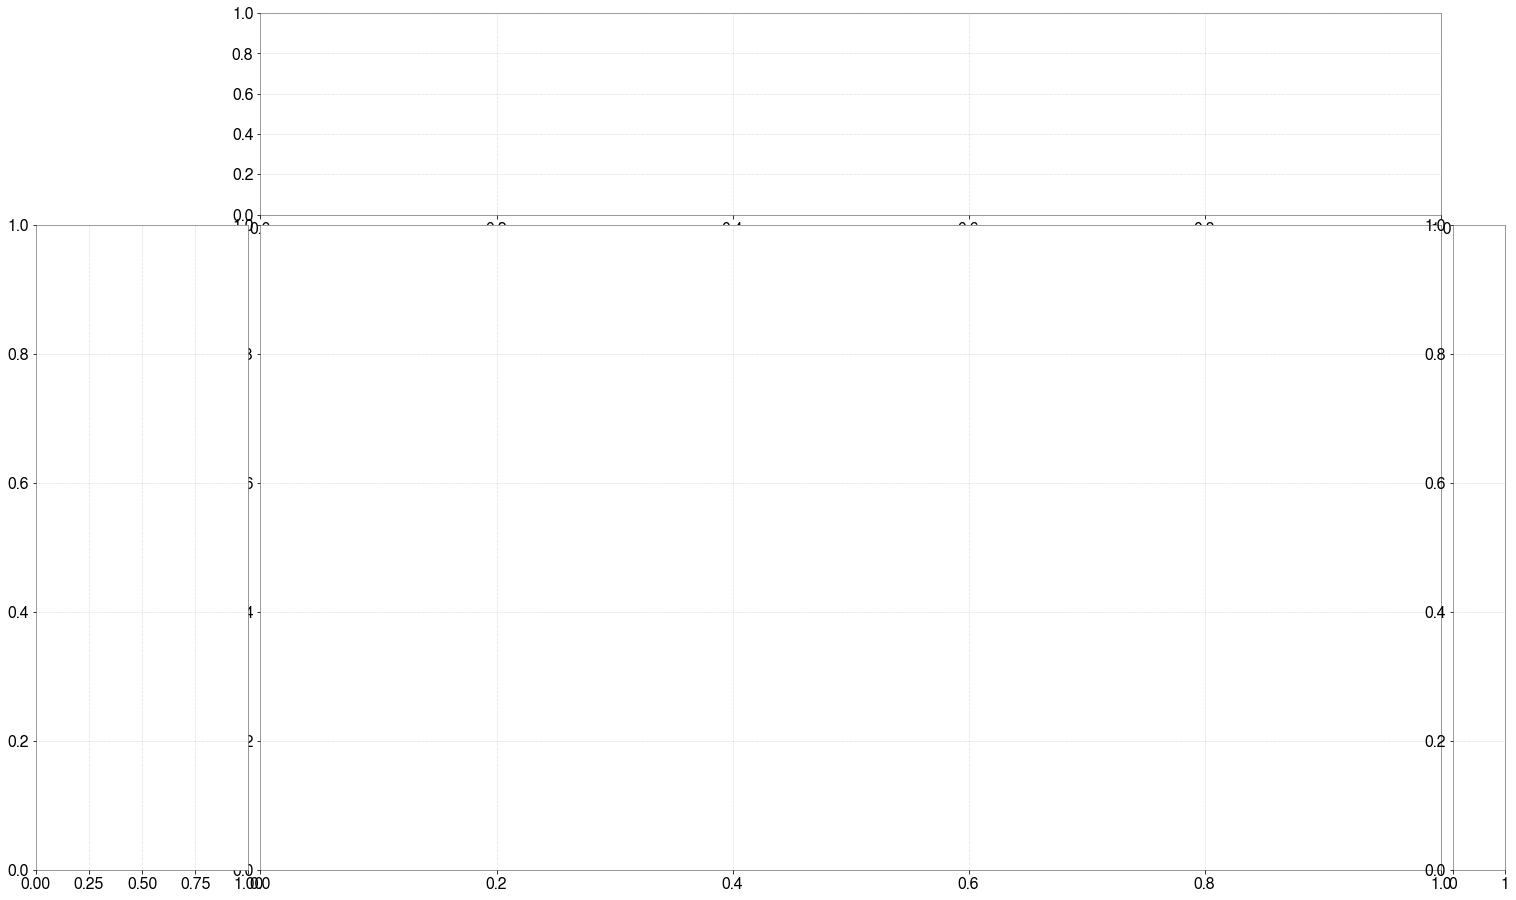

In [62]:
plot_spectrogram(data,0,5,funit='mHz',tunit='mins')